In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB as 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size=1)
        self.conv2 = nn.Conv2d(1, 29, kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv3 = nn.Conv2d(29, 59, kernel_size=3)
        self.maxpool3 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv4 = nn.Conv2d(59, 74, kernel_size=3)
        self.maxpool4 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1184, 300)
        self.fc2 = nn.Linear(300, nclasses)
        self.conv0_bn = nn.BatchNorm2d(3)
        self.conv1_bn = nn.BatchNorm2d(1)
        self.conv2_bn = nn.BatchNorm2d(29)
        self.conv3_bn = nn.BatchNorm2d(59)
        self.conv4_bn = nn.BatchNorm2d(74)
        self.dense1_bn = nn.BatchNorm1d(300)
    def forward(self, x):
        x =  F.relu(self.conv1_bn(self.conv1(self.conv0_bn(x))))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3( self.maxpool2(x))))
        x = F.relu(self.conv4_bn(self.conv4( self.maxpool3(x))))
        x = self.maxpool4(x)        
        x = x.view(-1, 1184)
        x = F.relu(self.fc1(x))
        x = self.dense1_bn(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, training=self.training)
        return F.log_softmax(x, dim=1)
        
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class MicronNetBF(nn.Module):
#     def __init__(self, num_classes: int = 43):
#         super().__init__()

#         # stage 1
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(3, 3, kernel_size=1, bias=False),
#             nn.BatchNorm2d(3),
#             nn.ReLU(inplace=True)
#         )

#         # stage 2
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(3, 29, kernel_size=3, bias=False),
#             nn.BatchNorm2d(29),
#             nn.ReLU(inplace=True)
#         )

#         # stage 3
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(29, 40, kernel_size=3, bias=False),
#             nn.BatchNorm2d(40),
#             nn.ReLU(inplace=True)
#         )

#         # stage 4
#         self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

#         self.conv4 = nn.Sequential(
#             nn.Conv2d(40, 59, kernel_size=3, bias=False),
#             nn.BatchNorm2d(59),
#             nn.ReLU(inplace=True)
#         )

#         # stage 5
#         self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

#         self.conv5 = nn.Sequential(
#             nn.Conv2d(59, 74, kernel_size=3, bias=False),
#             nn.BatchNorm2d(74),
#             nn.ReLU(inplace=True)
#         )

#         # stage 6
#         self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

#         # fully-connected head
#         self.fc1 = nn.Sequential(
#             nn.Linear(74 * 4 * 4, 300, bias=False),
#             nn.BatchNorm1d(300),
#             nn.ReLU(inplace=True)
#         )
#         self.fc2 = nn.Linear(300, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.pool1(x)

#         x = self.conv4(x)
#         x = self.pool2(x)

#         x = self.conv5(x)
#         x = self.pool3(x)

#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x


In [2]:
from __future__ import print_function
import argparse
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


batch_size =50                                                                                                                                                                                     
epochs = 70                                                                                                                                                                                                                                                                                                                                                                                 
seed = 1                                                                                                                                                                                           
log_interval=180                                                                                                                                                                                   
data = "data"                                                                                                                                                                                                                                                                                                                                                                                          
torch.manual_seed(1)                                                                                                                                                                               
lr = 0.007                                                                                                                                                                                          
momentum = 0.9                                                                                                                                                                                     
decay =  0.9996                                                                                                                                                                                        
step = 1000                                                                                                                                                                                        
l2_norm = 0.00001  
cuda = True
resume = False
# These may change as described in paper

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# from data import initialize_data, data_transforms 
# initialize_data("data") # extracts the zip files, makes a validation set
data_transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data + '/train_images',
                         transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)




val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data + '/val_images',
                         transform=data_transforms),
    batch_size=batch_size, shuffle=False, num_workers=1)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
if  cuda: 
    model.to(device)

if resume :
    state_dict = torch.load("model_28.pth")
    model.load_state_dict(state_dict) 



In [4]:
def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = Variable(data), Variable(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return validation_loss

def train(epoch , train_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target).cuda()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                # 100. * batch_idx / len(train_loader), loss.data[0]))
                100. * batch_idx / len(train_loader), loss.item()))


In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=l2_norm, nesterov=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)
best_val_loss = float('inf')

for epoch in range(1, epochs):
    train(epoch, train_loader)
    val_loss = validation()
    if epoch % step:
        scheduler.step()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_file = 'best_model.pth'
        torch.save(model.state_dict(), model_file)
        print('\nBest model updated and saved to ' + model_file)

Train Epoch: 1 [0/35339 (0%)]	Loss: 1.615807
Train Epoch: 1 [9000/35339 (25%)]	Loss: 1.368937
Train Epoch: 1 [18000/35339 (51%)]	Loss: 1.637118
Train Epoch: 1 [27000/35339 (76%)]	Loss: 1.612476

Validation set: Average loss: 1023.3083, Accuracy: 3725/3870 (96%)


Best model updated and saved to best_model.pth
Train Epoch: 2 [0/35339 (0%)]	Loss: 1.735775
Train Epoch: 2 [9000/35339 (25%)]	Loss: 1.315583
Train Epoch: 2 [18000/35339 (51%)]	Loss: 1.682572
Train Epoch: 2 [27000/35339 (76%)]	Loss: 1.351376

Validation set: Average loss: 2447.1482, Accuracy: 3398/3870 (88%)

Train Epoch: 3 [0/35339 (0%)]	Loss: 1.446374
Train Epoch: 3 [9000/35339 (25%)]	Loss: 1.277853
Train Epoch: 3 [18000/35339 (51%)]	Loss: 1.933936
Train Epoch: 3 [27000/35339 (76%)]	Loss: 1.579352

Validation set: Average loss: 858.1703, Accuracy: 3723/3870 (96%)


Best model updated and saved to best_model.pth
Train Epoch: 4 [0/35339 (0%)]	Loss: 1.508081
Train Epoch: 4 [9000/35339 (25%)]	Loss: 1.488083
Train Epoch: 4 [18000/

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load('best_model.pth', map_location=device)  
# if you saved a full checkpoint dict: state = checkpoint['state_dict']
model.load_state_dict(checkpoint)

model.to(device)


Net(
  (conv1): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(1, 29, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3): Conv2d(29, 59, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv4): Conv2d(59, 74, kernel_size=(3, 3), stride=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (conv3_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1184, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=43, bias=True)
  (conv0_bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(29, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [6]:
model.eval()


Net(
  (conv1): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(1, 29, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3): Conv2d(29, 59, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv4): Conv2d(59, 74, kernel_size=(3, 3), stride=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (conv3_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1184, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=43, bias=True)
  (conv0_bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(29, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [8]:
torch_model = Net()
example_inputs = (torch.randn(1, 3, 48, 48),)   # batch_size=1, 3‐channels, 48×48

torch.onnx.export(
    torch_model,
    example_inputs,
    "micronnet_gtsrb.onnx",
    opset_version=16,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}}
)

In [13]:
from torch.utils.data import DataLoader
from torchvision import datasets

test_loader = DataLoader(datasets.ImageFolder(data + '/val_images', transform=data_transforms), batch_size=64, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
        for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)       # if you’re computing loss/metrics
                outputs = model(inputs)           # forward pass
                preds = outputs.argmax(dim=1)     # for classification
                all_preds.append(preds)
                all_labels.append(labels)
                
# concatenate batchesfor inputs, labels in test_loader:
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)


In [14]:
accuracy = (all_preds == all_labels).float().mean().item()
print(f'Test Accuracy: {accuracy*100:.2f}%')

Test Accuracy: 99.07%


In [15]:
def accuracy(output: torch.Tensor,
             target: torch.Tensor,
             topk: tuple = (1, 5)) -> list:
    """
    Computes the accuracy over the k top predictions for the specified values of k.

    Args:
      output (Tensor): model outputs of shape (batch_size, num_classes)
      target (Tensor): ground-truth labels of shape (batch_size,)
      topk (tuple of int): which top-k accuracies to compute

    Returns:
      List[Tensor]: accuracies for each k in topk, in percent
    """
    maxk = max(topk)
    batch_size = target.size(0)

    # get the top maxk predictions for each sample
    # pred: shape (batch_size, maxk)
    _, pred = output.topk(maxk, dim=1, largest=True, sorted=True)
    # transpose to shape (maxk, batch_size) so we can compare rows easily
    pred = pred.t()
    # expand target to shape (maxk, batch_size) for comparison
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        # for top-k, consider the first k rows: correct[:k]
        # flatten and count how many are True
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        # convert to percentage
        res.append((correct_k * (100.0 / batch_size)).item())
    return res  # e.g. [top1_acc, top5_acc] if topk=(1,5)


In [16]:
model.eval()
topk = (1, 5)               # compute Top-1 and Top-5
total_top1 = 0.0
total_topk = {k: 0.0 for k in topk}
n_batches = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        accs = accuracy(outputs, labels, topk=topk)
        # accs[0] is Top-1, accs[1] is Top-5, etc.
        total_top1 += accs[0]
        for idx, k in enumerate(topk):
            total_topk[k] += accs[idx]
        n_batches += 1

# average over batches
avg_top1 = total_top1 / n_batches
avg_topk = {k: total_topk[k] / n_batches for k in topk}

print(f"Average Top-1 Accuracy: {avg_top1:.2f}%")
for k in topk:
    print(f"Average Top-{k} Accuracy: {avg_topk[k]:.2f}%")


Average Top-1 Accuracy: 99.08%
Average Top-1 Accuracy: 99.08%
Average Top-5 Accuracy: 99.97%


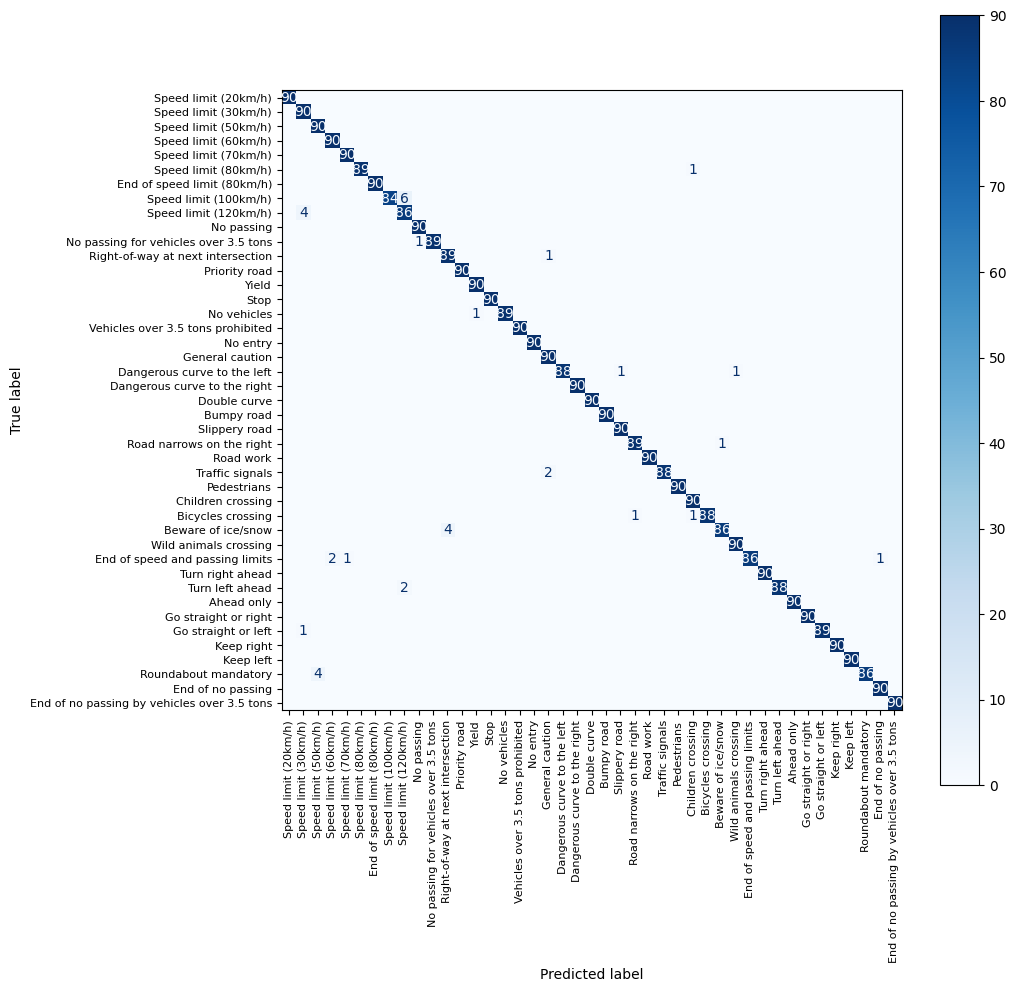

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Convert predictions and labels to numpy arrays
y_true = all_labels.cpu().numpy()
y_pred = all_preds.cpu().numpy()

# Compute the confusion matrix
cm_new = confusion_matrix(y_true, y_pred)

# Create a display instance using your class names as labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=class_names)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
# Replace class names with the GTSRB names and update tick labels on the axes
new_labels = ["Speed limit (20km/h)",
              "Speed limit (30km/h)",
              "Speed limit (50km/h)",
              "Speed limit (60km/h)",
              "Speed limit (70km/h)",
              "Speed limit (80km/h)",
              "End of speed limit (80km/h)",
              "Speed limit (100km/h)",
              "Speed limit (120km/h)",
              "No passing",
              "No passing for vehicles over 3.5 tons",
              "Right-of-way at next intersection",
              "Priority road",
              "Yield",
              "Stop",
              "No vehicles",
              "Vehicles over 3.5 tons prohibited",
              "No entry",
              "General caution",
              "Dangerous curve to the left",
              "Dangerous curve to the right",
              "Double curve",
              "Bumpy road",
              "Slippery road",
              "Road narrows on the right",
              "Road work",
              "Traffic signals",
              "Pedestrians",
              "Children crossing",
              "Bicycles crossing",
              "Beware of ice/snow",
              "Wild animals crossing",
              "End of speed and passing limits",
              "Turn right ahead",
              "Turn left ahead",
              "Ahead only",
              "Go straight or right",
              "Go straight or left",
              "Keep right",
              "Keep left",
              "Roundabout mandatory",
              "End of no passing",
              "End of no passing by vehicles over 3.5 tons"]

ax.set_xticklabels(new_labels, rotation=90, fontsize=8)
ax.set_yticklabels(new_labels, fontsize=8)

# Remove text labels that are '0'
for text in ax.texts:
    if text.get_text() == '0':
        text.set_text("")

plt.show()

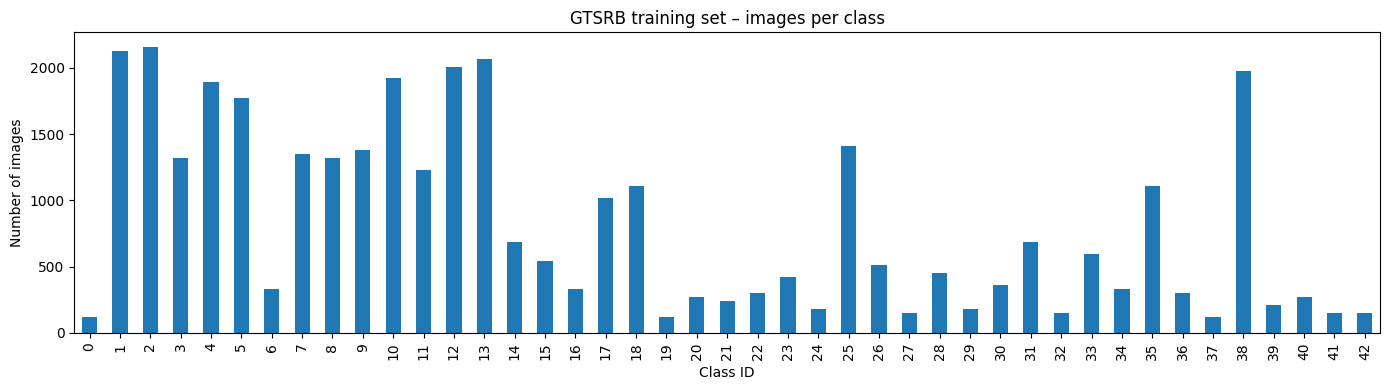

In [6]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

root = Path("./data/train_images")  # adjust if needed
records = []

for class_dir in sorted(root.iterdir()):
    # Only process directories with a numeric name
    if class_dir.name.isdigit():
        cid = int(class_dir.name)
        num_images = len(list(class_dir.glob("*.ppm")))
        records.append({"ClassId": cid, "Count": num_images})

df = pd.DataFrame(records).set_index("ClassId").sort_index()

plt.figure(figsize=(14,4))
df["Count"].plot.bar()
plt.title("GTSRB training set – images per class")
plt.xlabel("Class ID")
plt.ylabel("Number of images")
plt.tight_layout()
plt.show()